## 3. Octave and one-third octave band filters

In this notebook we'll go through designing and appyling **fractional band-pass filtering** (mainly 1/1 and 1/3 octave filters) to our already processed signal.

Once we have applied a **frequency weighting filter to the signal** we can obtain a measure of the **global sound pressure level for a certain time interval of interest**. That's nice but, if we want to have **information as to the frequencies in which the measured signal has a high SPL** we need to split this global level in a per-frequency-band indicator.

For that, we will **apply band-pass filters to our signal**. The amount of pass-bands filters to apply will be determined by how many different frequency bands we'd like our measurement to be split in. We will explore **1/1 octave and 1/3 octave filters**, increasing three times the amount of bands for the latter.

## Filter specifications

The band-pass filters used for acoustical measurements are defined by the **IEC 61260 standard**. In it, the **templates that these filters should follow are specified**. The requirements are given in **two Class based on their performance: Class 1 and Class 2**. Both have the **same design objectives but they different in the acceptance limit**. 

Since the filters are defined on a logarithmic scale, **all filters of the same family should have the same response**. So, only one response is specified with the **mid-band frequency normalized to 1**.

For each of the filters, the **exact mid-band frequency** can be determined from the following expression: 

$$ f_m = f_rG^{x/b}, \ \text{when b is odd} $$

$$ f_m = f_rG^{(2x+1)/b}, \ \text{when b is even} $$

Where $ f_r $ is the **reference frequency**, $ G = 10^{0.3} $ is the **octave frequency ratio** (that represents the distance between frequencies that is equal to an octave band), and $ 1/b $ is the **bandwidth designator** (1/1 for octave and 1/3 for third-octave bands, and so on).

Next, we'll bring over these variables that will allow us to visualize and build our filters.

In [46]:
import numpy as np

# Reference frequency
FR = 1000.0

# Octave frequency ratio
G = 10**(3/10)

# Exact third-octave mid-band frequencies
fto_mid = np.array([FR*G**(x/3) for x in np.arange(33)-19])

# Exact octave band mid-band frequencies
foct_mid = np.array([FR*G**(x) for x in np.arange(11)-6])

# Nominal third-octave mid-band frequencies
fto_nom = np.array([ 12.5, 16.0, 20.0, 25.0, 31.5, 40.0, 50.0, 63.0, 80.0, 100.0, 
                    125.0, 160.0, 200.0, 250.0, 315.0, 400.0, 500.0, 630.0, 800.0, 
                    1000.0, 1250.0, 1600.0, 2000.0, 2500.0, 3150.0, 4000.0, 5000.0,
                    6300.0, 8000.0, 10000.0, 12500.0, 16000.0, 20000.0])

# Nominal octave band mid-band frequencies
foct_nom = fto_nom[1::3]

Great! Now we have both the **nominal and exact mid-band frequencies for both the octave and third-octave frequency filters**. 

Before moving on to calculating the **upper and lower boundary frequencies**, we'll get the standard's specification for designing the filters and **plot the templates for the Class 1 octave and third-octave band-pass filters**.

(0.5, 2)

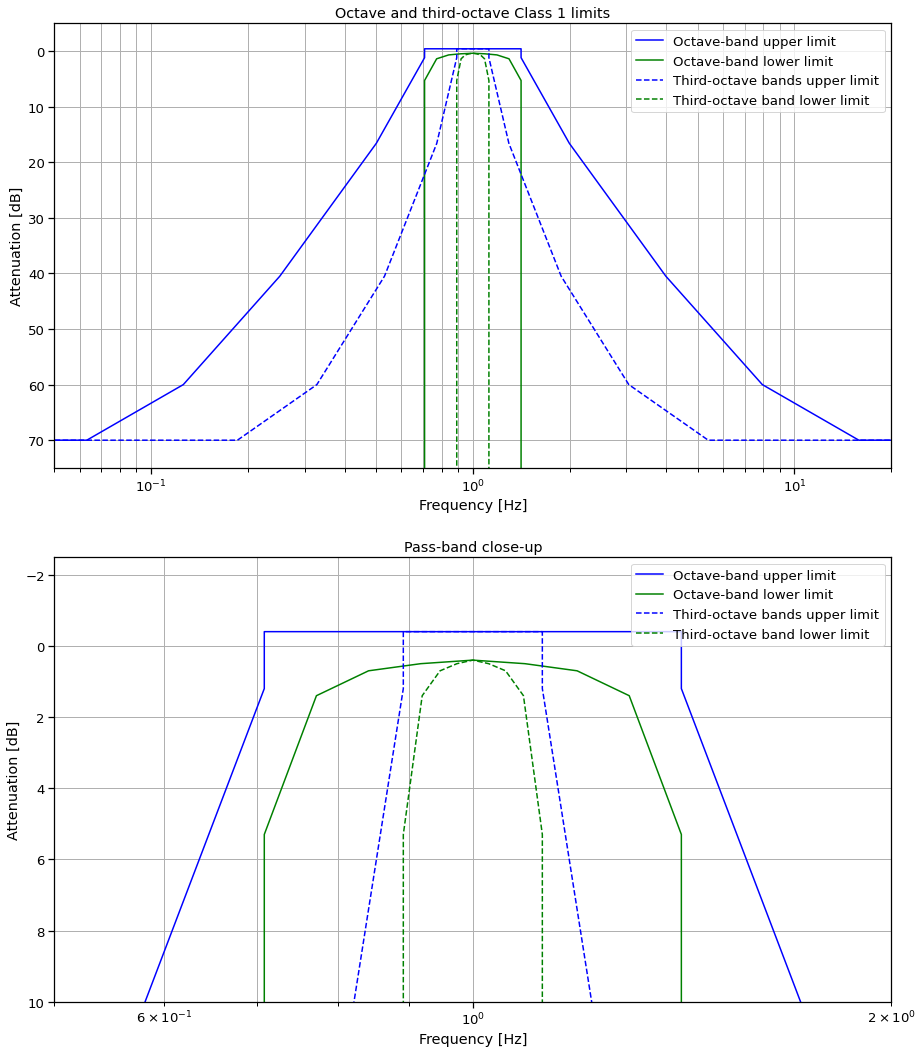

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (15,9)
sns.set_context('notebook', font_scale=1.2)

# minimum absolute representable float
eps = np.finfo(float).eps

# a very big number
inf = 10**5

# Standard definitions
# - - - - - - - - - - - - - - - 

# Octave-band frequency array
x_t_oct = np.array([-inf, G**-4, G**-3, G**-2, 
                    G**-1, G**(-1/2-eps), G**(-1/2+eps),
                    G**(-3/8), G**(-1/4), G**(-1/8),
                    1, G**(1/8), G**(1/4), G**(3/8),
                    G**(1/2-eps), G**(1/2+eps), G**1,
                    G**2, G**3, G**4, inf])

# Third-octave band frequency array
x_t_to = np.array([-inf, 0.18546, 0.32748, 0.53143, 0.77257, 
                   0.89125-eps, 0.89125+eps, 0.91958, 0.94719, 
                   0.97402, 1, 1.02667, 1.05575, 1.08746, 
                   1.12202-eps, 1.12202+eps, 1.29437, 
                    1.88173, 3.05365, 5.39195, inf])

# Class 1 upper tolerance
y_upp = np.array([70, 70, 60, 40.5, 16.6, 1.2, -0.4, -0.4, 
                  -0.4, -0.4, -0.4, -0.4, -0.4, -0.4, 
                  -0.4, 1.2, 16.6, 40.5, 60, 70, 70])

# Class 1 lower tolerance
y_low = np.array([inf, inf, inf, inf, inf, inf, 5.3, 1.4,
                  0.7, 0.5, 0.4, 0.5, 0.7, 1.4, 5.3, 
                  inf, inf, inf, inf, inf, inf])

# Plotting
# - - - - - - - - - - - - - - - 

fig, ax = plt.subplots(2, 1, figsize=(15,18))

for ax_ in ax:
    ax_.plot(x_t_oct, y_upp, c='b', label='Octave-band upper limit')
    ax_.plot(x_t_oct, y_low, c='g', label='Octave-band lower limit')
    ax_.plot(x_t_to, y_upp, '--', c='b', label='Third-octave bands upper limit')
    ax_.plot(x_t_to, y_low, '--', c='g', label='Third-octave band lower limit')
    ax_.set_xscale('log')
    ax_.grid('on', which='both')
    ax_.legend()
    ax_.set_xlabel('Frequency [Hz]')
    ax_.set_ylabel('Attenuation [dB]')
    
ax[0].set_title('Octave and third-octave Class 1 limits')
ax[1].set_title('Pass-band close-up')

ax[0].set_ylim([75, -5])
ax[0].set_xlim([5*10**-2, 20])

ax[1].set_ylim([10, -2.5])
ax[1].set_xlim([5*10**-1, 2])

Having our templates for **all of the filters belonging to the family 

In [37]:
# missing after templates
def frec_lim(frec_cen, n_oct=1.0):
    """ Devuelve las frecuencias lí­mites (inferior y superior), para
    bandas de tercio de octava y octavas, según los valores medios exactos
    de las bandas y el número de bandas por octava. """
    return np.around(frec_cen*oct_ratio**(-1/(2*n_oct)), 5), np.around(frec_cen*oct_ratio**(1/(2*n_oct)), 5)

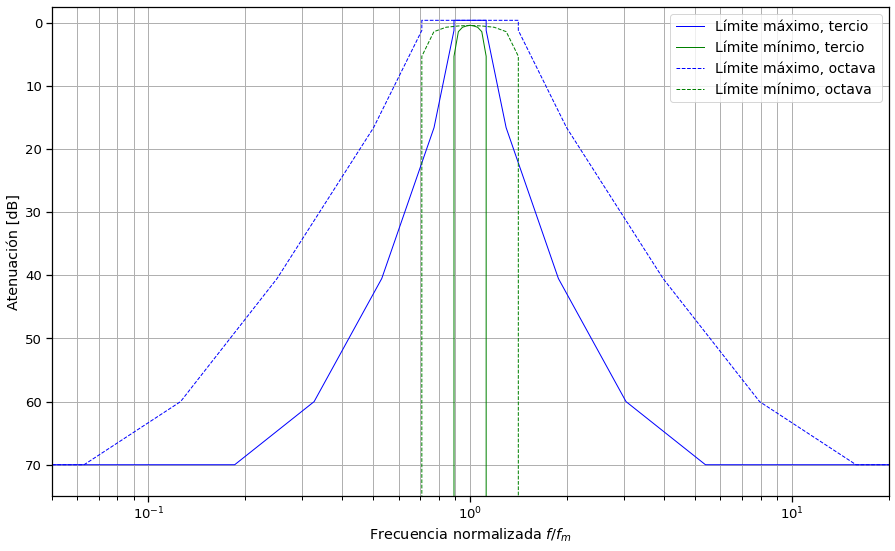

<Figure size 1080x648 with 0 Axes>

In [63]:


plt.plot(xto, ymaxcl1, linewidth=1, color='b', label='Límite máximo, tercio')
plt.plot(xto, ymincl1, linewidth=1, color='g', label='Límite mínimo, tercio')

plt.plot(xoct, ymaxcl1, '--', linewidth=1, color='b', label='Límite máximo, octava')
plt.plot(xoct, ymincl1, '--', linewidth=1, color='g', label='Límite mínimo, octava')

#plt.plot(xto, ymaxcl2, linewidth=1, color='b')
#plt.plot(xto, ymincl2, linewidth=1, color='g')

#plt.plot(xoct, ymaxcl2, '--', linewidth=1, color='b')
#plt.plot(xoct, ymincl2, '--', linewidth=1, color='g')

plt.xscale('log')
plt.gca().invert_yaxis()

plt.xlabel('Frecuencia normalizada 'r'$f/f_m$')
plt.ylabel('Atenuación [dB]')
#plt.xticks(np.arange(9000))
#plt.ylim([6, -2.5])
plt.ylim([75, -2.5])
#plt.xlim([6/10, 10/6])
plt.xlim([1/20, 20])

plt.grid(which='both', axis='both')
plt.legend(fontsize=14)
plt.show()

plt.tight_layout()

In [56]:
fs = 48000 # Frecuencia de Sampleo [Hz]
fr = 1000.0 # Frecuencia de Referencia: [Hz]

fto_nom = np.array([ 12.5, 16.0, 20.0, 25.0, 31.5, 40.0, 50.0, 63.0,
    80.0, 100.0, 125.0, 160.0, 200.0, 250.0, 315.0, 400.0, 500.0, 630.0,
    800.0, 1000.0, 1250.0, 1600.0, 2000.0, 2500.0, 3150.0, 4000.0, 5000.0,
    6300.0, 8000.0, 10000.0, 12500.0, 16000.0, 20000.0
])
foct_nom = fto_nom[1::3]

oct_ratio = np.around(10.0**(3.0/10.0), 5) # Según ecuación 1

def frec_a_num(frecs = fto_nom, frec_ref = fr, n_oct = 3.0):
    """Devuelve el número de banda para las frecuencias centrales ingresadas,
    correspondiendo la banda 0 a la frecuencia de referencia.
    n_oct representa el número de bandas por octava, siendo 1.0 para octavas
    y 3.0 para tercios de octava."""
    return np.round(n_oct*np.log2(frecs/frec_ref))

def frec_cen(nband = np.arange(-6, 5), frec_ref = fr, n_oct = 3.0):
    """Calcula las frecuencias centrales exactas para bandas de octava y
    tercios de octava. Recibe los números de banda a calcular, la
    frecuencia de referencia, y el número de bandas por octava."""
    return np.around(frec_ref*oct_ratio**(nband/n_oct), 5)

def frec_lim(frec_cen, n_oct = 3.0):
    return np.around(frec_cen*oct_ratio**(-1/(2*n_oct)), 5), np.around(frec_cen*oct_ratio**(1/(2*n_oct)), 5)

# Para tercios

nb_to = frec_a_num(fto_nom, fr, 3.0)
fto_cen = frec_cen(nb_to, fr, 3.0)
f_inf, f_sup = frec_lim(fto_cen, 3.0)

print('Inf: ',f_inf)
print('Sup: ',f_sup)

def but_pb(inf, sup, fs=fs, order=4):
    nyq = 0.5*fs
    low = inf/nyq
    high = sup/nyq
    sos = butter(order, [low, high], btype='band', output='sos')
    return sos

#    w, h = sosfreqz(sos, worN=100000)
#    plt.plot((fs*0.5/np.pi)*w, 20*np.log10(abs(h)))

#for i in range(len(foct_nom)):
#        but_pb_global(f_inf[i], f_sup[i]) # Por defecto, fs = 48000, orden = 4

## Indice
#i = 0
#i = 9
i = 19
i = 29
i= 31

#inf = f_inf[i]
#sup = f_sup[i]

inf = f_inf[i-1]
sup = f_sup[i+1]

sos = but_pb(inf, sup)
w, h = sosfreqz(sos, worN=20000)

epsilon = 0.000001
inf = 10**10
x = np.array([oct_ratio**-4, oct_ratio**-3, oct_ratio**-2, oct_ratio**-1, oct_ratio**(-1/2-epsilon),
    oct_ratio**(-1/2+epsilon), oct_ratio**(-3/8), oct_ratio**(-1/4), oct_ratio**(-1/8),
    1, oct_ratio**(1/8), oct_ratio**(1/4), oct_ratio**(3/8), oct_ratio**(1/2-epsilon),
    oct_ratio**(1/2+epsilon), oct_ratio**1, oct_ratio**2, oct_ratio**3, oct_ratio**4])

ymax = np.array([70, 60, 40.5, 16.6, 1.2, -0.4, -0.4, -0.4, -0.4, -0.4, -0.4, -0.4,
    -0.4, -0.4, 1.2, 16.6, 40.5, 60, 70])
ymin = np.array([inf, inf, inf, inf, inf, 5.3, 1.4, 0.7, 0.5, 0.4, 0.5, 0.7, 1.4,
    5.3, inf, inf, inf, inf, inf])

xi = x*fto_cen[i]

#plt.plot(xi, ymax, '-.', linewidth=0.85, color='b', label='Límite máximo')
plt.plot(xi, ymax, '-.', linewidth=1, color='b', label='Límite máximo')

plt.plot((fs*0.5/np.pi)*w, abs(20*np.log10(abs(h))), color='r', linewidth=2.0, label='Filtro %1.0f Hz'%fto_nom[i])
#plt.plot((fs*0.5/np.pi)*w, abs(20*np.log10(abs(h))), color='r', linewidth=1.2, label='Filtro %1.0f Hz'%fto_nom[i])

#plt.plot(xi, ymin, '-.', linewidth=0.85, color='g', label='Límite mínimo')
plt.plot(xi, ymin, '-.', linewidth=1, color='g', label='Límite mínimo')

plt.xscale('log')
plt.gca().invert_yaxis()
#plt.title('Banco de filtros de octava',fontsize=14)
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Atenuación [dB]')
plt.ylim([70, -5])
plt.xlim([0.01*fto_cen[i], 100*fto_cen[i]])
plt.ylim([3, -1.5])
plt.xlim([0.5*fto_cen[i], 2*fto_cen[i]])
plt.grid(which='both', axis='both')
plt.legend()
plt.show()

"""
epsilon = 0.000001
inf = 10**10
x = np.array([oct_ratio**-4, oct_ratio**-3, oct_ratio**-2, oct_ratio**-1, oct_ratio**(-1/2-epsilon),
    oct_ratio**(-1/2+epsilon), oct_ratio**(-3/8), oct_ratio**(-1/4), oct_ratio**(-1/8),
    1, oct_ratio**(1/8), oct_ratio**(1/4), oct_ratio**(3/8), oct_ratio**(1/2-epsilon),
    oct_ratio**(1/2+epsilon), oct_ratio**1, oct_ratio**2, oct_ratio**3, oct_ratio**4])

ymax = np.array([70, 60, 40.5, 16.6, 1.2, -0.4, -0.4, -0.4, -0.4, -0.4, -0.4, -0.4,
    -0.4, -0.4, 1.2, 16.6, 40.5, 60, 70])
ymin = np.array([inf, inf, inf, inf, inf, 5.3, 1.4, 0.7, 0.5, 0.4, 0.5, 0.7, 1.4,
    5.3, inf, inf, inf, inf, inf])

plt.plot(x, ymin, '-.', linewidth=2, color='g', label='Límite mínimo')
plt.plot(x, ymax, '-.', linewidth=2, color='b', label='Límite máximo')
plt.xscale('log')
#plt.gca().invert_yaxis()
#plt.title('Banco de filtros de octava',fontsize=14)
plt.xlabel('Frecuencia normalizada 'r'$f/f_m$', fontsize=12)
plt.ylabel('Amplitud [dB]', fontsize=12)
plt.ylim([15, -2])
plt.xlim([0.5, 2])
#plt.ylim([70, -5])
#plt.xlim([0.05, 20])
plt.grid(which='both', axis='both')
plt.legend()
plt.show()
"""


Inf:  [1.12202700e+01 1.41254700e+01 1.77829100e+01 2.23873500e+01
 2.81840000e+01 3.54815400e+01 4.46686000e+01 5.62344100e+01
 7.07948900e+01 8.91254600e+01 1.12202260e+02 1.41254220e+02
 1.77828460e+02 2.23872680e+02 2.81838890e+02 3.54814010e+02
 4.46684200e+02 5.62341870e+02 7.07946190e+02 8.91251110e+02
 1.12201823e+03 1.41253673e+03 1.77827769e+03 2.23871811e+03
 2.81837803e+03 3.54812635e+03 4.46682469e+03 5.62339694e+03
 7.07943457e+03 8.91247664e+03 1.12201390e+04 1.41253126e+04
 1.77827081e+04]
Sup:  [1.41254800e+01 1.77829100e+01 2.23873500e+01 2.81840000e+01
 3.54815400e+01 4.46685900e+01 5.62344100e+01 7.07949000e+01
 8.91254500e+01 1.12202260e+02 1.41254220e+02 1.77828460e+02
 2.23872670e+02 2.81838900e+02 3.54814010e+02 4.46684200e+02
 5.62341870e+02 7.07946190e+02 8.91251110e+02 1.12201824e+03
 1.41253672e+03 1.77827769e+03 2.23871811e+03 2.81837803e+03
 3.54812635e+03 4.46682470e+03 5.62339694e+03 7.07943457e+03
 8.91247664e+03 1.12201390e+04 1.41253126e+04 1.77827081

NameError: name 'butter' is not defined